# Demand Prediction Project Notebook

1. Importing Libraries

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

2. Loading the Data

In [24]:
df = pd.read_csv('C:\\Users\\ADMIN\\Desktop\\intern_prj\\product_demand_prediction_dataset.csv')

3. Data Exploration

In [26]:
print(df.head())
print(df.info())
print(df.describe())
print(df.isnull().sum())

  ProductID StoreID        Date  Sales  Price Promotion  Season Holiday  \
0      P005    S001  2023-01-01    264  43.11       Yes  Spring      No   
1      P004    S003  2023-01-02    281   9.09        No  Summer      No   
2      P001    S003  2023-01-03    395  46.34        No    Fall     Yes   
3      P002    S001  2023-01-04     33   8.75       Yes  Spring     Yes   
4      P001    S002  2023-01-05    158  38.30       Yes    Fall      No   

   DayOfWeek  CompetitorPrice  EconomicIndicator Weather  StockLevel  Demand  
0     Sunday            16.44               1.14   Snowy         921     450  
1     Monday            39.59               0.81   Sunny         853      55  
2    Tuesday            36.01               1.11   Sunny         495      82  
3  Wednesday             6.27               0.91   Sunny         959      35  
4   Thursday            26.67               0.86   Sunny         571      58  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
D

4. Outlier Handling

In [29]:
upper_limit = df['Demand'].quantile(0.95)
df['Demand'] = np.where(df['Demand'] > upper_limit, upper_limit, df['Demand'])

5. Feature Engineering

In [32]:
df['Lag_1'] = df['Sales'].shift(1)
df['Lag_7'] = df['Sales'].shift(7)
df['Lag_14'] = df['Sales'].shift(14)
df['Lag_30'] = df['Sales'].shift(30)
df['Moving_Avg_7'] = df['Sales'].rolling(window=7).mean()
df['Moving_Avg_14'] = df['Sales'].rolling(window=14).mean()
df['Moving_Avg_30'] = df['Sales'].rolling(window=30).mean()

6. Interaction Terms and Temporal Features

In [34]:
df['Price_Promo'] = df['Price'] * (df['Promotion'] == 'Yes').astype(int)
df['Day_of_Year'] = pd.to_datetime(df['Date']).dt.dayofyear
df['DayOfWeek_Sin'] = np.sin(2 * np.pi * df['DayOfWeek'].astype('category').cat.codes / 7)
df['DayOfWeek_Cos'] = np.cos(2 * np.pi * df['DayOfWeek'].astype('category').cat.codes / 7)
df = df.dropna()

7. Preparing Features and Target Variable

In [36]:
X = df.drop(columns=['Demand', 'Date'])
y = df['Demand']

8. Data Preprocessing

In [38]:
categorical_features = ['ProductID', 'StoreID', 'Promotion', 'Season', 'Holiday', 'DayOfWeek', 'Weather']
numerical_features = ['Sales', 'Price', 'CompetitorPrice', 'EconomicIndicator', 'StockLevel', 
                     'Lag_1', 'Lag_7', 'Lag_14', 'Lag_30', 'Moving_Avg_7', 'Moving_Avg_14', 
                     'Moving_Avg_30', 'Price_Promo', 'Day_of_Year', 'DayOfWeek_Sin', 'DayOfWeek_Cos']

numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

X_processed = preprocessor.fit_transform(X)

9. Train-Test Split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

10. Hyperparameter Tuning

In [42]:
models = {
    "LightGBM": LGBMRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(random_state=42)
}

param_grids = {
    "LightGBM": {
        'n_estimators': [100, 200],
        'num_leaves': [31, 40, 50, 60],
        'max_depth': [-1, 10, 20, 30],
        'learning_rate': [0.001, 0.01, 0.05, 0.1],
        'min_child_samples': [10, 20, 30],
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
        'reg_alpha': [0, 0.1, 0.5],
        'reg_lambda': [0, 0.1, 0.5]
    },
    "XGBoost": {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    },
    "RandomForest": {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
}

best_models = {}
for model_name, model in models.items():
    print(f"Tuning {model_name}...")
    grid_search = RandomizedSearchCV(estimator=model, 
                                     param_distributions=param_grids[model_name], 
                                     n_iter=20, 
                                     cv=3, 
                                     scoring='neg_mean_absolute_error', 
                                     n_jobs=-1,
                                     random_state=42)
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best {model_name} params: {grid_search.best_params_}")


Tuning LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3395
[LightGBM] [Info] Number of data points in the train set: 3976, number of used features: 44
[LightGBM] [Info] Start training from score 249.037223
Best LightGBM params: {'subsample': 0.6, 'reg_lambda': 0.1, 'reg_alpha': 0, 'num_leaves': 60, 'n_estimators': 100, 'min_child_samples': 30, 'max_depth': -1, 'learning_rate': 0.001, 'colsample_bytree': 0.6}
Tuning XGBoost...
Best XGBoost params: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Tuning RandomForest...
Best RandomForest params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 10}


11. Model Evaluation

In [48]:
from sklearn.metrics import mean_squared_error, r2_score

mae_scores = {}
mse_scores = {}
r2_scores = {}
efficiency_scores = {}

for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    
    
    mae = mean_absolute_error(y_test, y_pred)
    mae_scores[model_name] = mae
  
    mse = mean_squared_error(y_test, y_pred)
    mse_scores[model_name] = mse
    
    
    r2 = r2_score(y_test, y_pred)
    r2_scores[model_name] = r2
    
    
    non_zero_indices = y_test != 0
    if np.any(non_zero_indices):
        efficiency = np.mean(y_pred[non_zero_indices] / y_test[non_zero_indices])
    else:
        efficiency = 0

    efficiency_scores[model_name] = efficiency
    
    print(f"{model_name} MAE: {mae}, MSE: {mse}, R²: {r2:.2f}, Efficiency: {efficiency:.2f}")


LightGBM MAE: 127.40465814215787, MSE: 21367.654516662555, R²: -0.00, Efficiency: 4.30
XGBoost MAE: 127.49740826244086, MSE: 21393.22731830408, R²: -0.00, Efficiency: 4.30
RandomForest MAE: 128.13783132843653, MSE: 21644.529819336807, R²: -0.01, Efficiency: 4.33


12. Blended Predictions

In [50]:
def blend_predictions(models, X):
    predictions = np.zeros((X.shape[0], len(models)))
    for i, model in enumerate(models):
        predictions[:, i] = model.predict(X)
    return predictions.mean(axis=1)


blended_preds = blend_predictions(best_models.values(), X_test)


blended_mae = mean_absolute_error(y_test, blended_preds)


blended_mse = mean_squared_error(y_test, blended_preds)


blended_r2 = r2_score(y_test, blended_preds)


non_zero_indices = y_test != 0  
if np.any(non_zero_indices):
    blended_efficiency = np.mean(blended_preds[non_zero_indices] / y_test[non_zero_indices])
else:
    blended_efficiency = 0


print(f"Blended Model MAE: {blended_mae}, MSE: {blended_mse}, R²: {blended_r2:.2f}, Blended Efficiency: {blended_efficiency:.2f}")


Blended Model MAE: 127.63654663139329, MSE: 21431.796811884542, R²: -0.00, Blended Efficiency: 4.31


13. Feature Importance Visualization

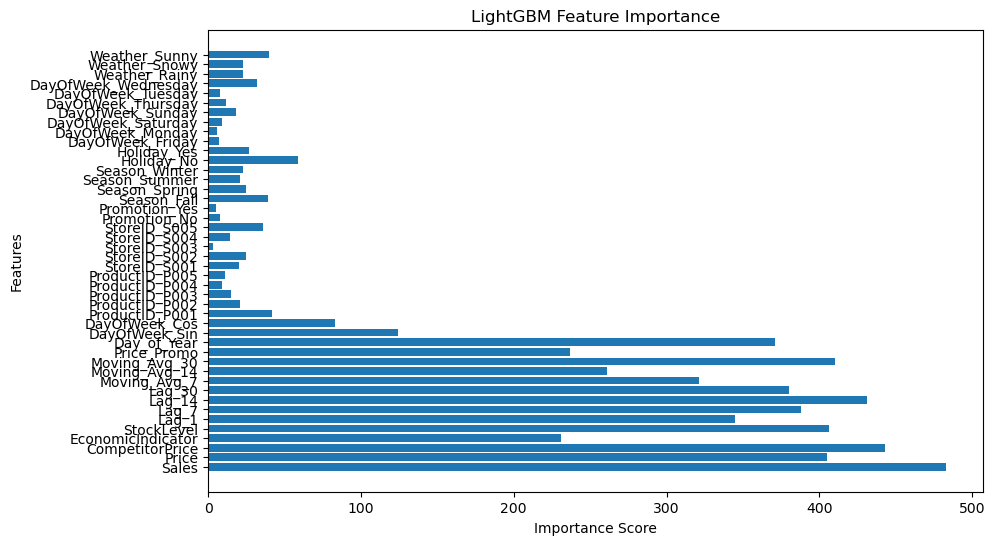

In [52]:
best_lgbm = best_models["LightGBM"]
categorical_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
numerical_feature_names = numerical_features
all_feature_names = np.concatenate([numerical_feature_names, categorical_feature_names])

plt.figure(figsize=(10, 6))
plt.barh(all_feature_names, best_lgbm.feature_importances_)
plt.title('LightGBM Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()
